# Insper: Profa Maria Kelly Venezuela

# Ciência dos dados: Engenharias

# Projeto 3: PNADC - Uso dos microdados de 2023

# Grupo: Danilo Ramos, Leonardo Veras e Thomas Ganut
___


In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from funcao import regress, pega_variaveis

___
## A. Introdução

### Objetivo escolhido:

O **tema** escolhido pelo grupo é como a classe social e a área de atuação podem determinar o salário de um indíviduo.
<br><br>

O ***target*** escolhido pelo grupo é "Qual era o rendimento bruto/retirada mensal que ... recebia/fazia normalmente nesse trabalho? (valor em dinheiro)" (variável V403312 - quantitativa).

O grupo dividiu as ***features*** escolhidas para o projeto em três temas, sendo estes "Classe social", "Área de atuação" e "Classificações gerais".

#### Classe social
- Cor ou raça (V2010)
- ... sabe ler e escrever? (V3001)
- A escola que ... frequenta é de (V3002A)
- Nível de instrução mais elevado alcançado (pessoas de 5 anos ou mais de idade) padronizado para o Ensino fundamental -  SISTEMA DE 9 ANOS (VD3004)

#### Área de atuação
- Nesse trabalho, ... tinha carteira de trabalho assinada? (V4029)

#### Classificações gerais
- Unidade da Federação (UF)
- Tipo de área (V1023)
- Idade do morador na data de referência (V2009)

___
# Leitura da base de dados - PNADC 2023:

In [138]:
df = pd.read_csv('output.csv')

print(len(df))

473335


In [139]:
# sns.pairplot(df)
# plt.tight_layout()
# plt.show()

In [140]:
# Mudando o tipo para 'category'
colunas = ['Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao']
for coluna in colunas:
    df[coluna] = df[coluna].astype('category')

# Renomeando as categorias
df['Estado'] = df['Estado'].cat.rename_categories({
    11: 'Rondônia', 12: 'Acre', 13: 'Amazonas', 14: 'Roraima', 15: 'Pará', 16: 'Amapá', 17: 'Tocantins', 
    21: 'Maranhão', 22: 'Piauí', 23: 'Ceará', 24: 'Rio Grande do Norte', 25: 'Paraíba', 26: 'Pernambuco', 27: 'Alagoas', 28: 'Sergipe', 29: 'Bahia', 
    31: 'Minas Gerais', 32: 'Espírito Santo', 33: 'Rio de Janeiro', 35: 'São Paulo', 
    41: 'Paraná', 42: 'Santa Catarina', 43: 'Rio Grande do Sul', 
    50: 'Mato Grosso do Sul', 51: 'Mato Grosso', 52: 'Goiás', 53: 'Distrito Federal'
})

df['AreaRes'] = df['AreaRes'].cat.rename_categories({
    1: 'Capital', 2: "Resto da RM", 3: 'Resto da RIDE', 4: 'Resto da UF' # RIDE = Região Integrada de Desenvolvimento Econômico
})

df['CorRaca'] = df['CorRaca'].cat.rename_categories({
    1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indigena', 9: 'Ignorado' 
})

df['Analfabeto'] = df['Analfabeto'].cat.rename_categories({
    1: 'Não', 2: 'Sim'
})

df['Carteira'] = df['Carteira'].cat.rename_categories({
    1: 'Sim', 2: 'Nao'
})

df['Instrucao'] = df['Instrucao'].cat.rename_categories({
    1: '<1 ano', 2: 'Fund. incompleto', 3: 'Fund. completo', 4: 'EM incompleto', 5: 'EM completo', 6: 'Sup. incompleto', 7: 'Sup. completo', 
})

# pd.Categorical
# df['Estado'] = pd.Categorical(df['Estado'], categories=[
#     'Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins', 'Maranhão', 
#     'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 
#     'Bahia', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo', 'Paraná', 
#     'Santa Catarina', 'Rio Grande do Sul', 'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 
#     'Distrito Federal'
# ], ordered=False)

# df['AreaRes'] = pd.Categorical(df['AreaRes'], categories=[
#     'Capital', 'Resto da RM', 'Resto da RIDE', 'Resto da UF'
# ], ordered=False)

# df['CorRaca'] = pd.Categorical(df['CorRaca'], categories=[
#     'Branca', 'Preta', 'Amarela', 'Parda', 'Indigena', 'Ignorado'
# ], ordered=False)

# df['Analfabeto'] = pd.Categorical(df['Analfabeto'], categories=[
#     'Não', 'Sim'
# ], ordered=False)

# df['Carteira'] = pd.Categorical(df['Carteira'], categories=[
#     'Sim', 'Nao'
# ], ordered=False)

# df['Instrucao'] = pd.Categorical(df['Instrucao'], categories=[
#     '<1 ano', 'Fund. incompleto', 'Fund. completo', 'EM incompleto', 'EM completo', 
#     'Sup. incompleto', 'Sup. completo'
# ], ordered=True)

In [141]:
# Limita a idade entre 18 e 62 anos (maior de idade e não aposentado)
# Limpa os NaN das colunas 'Salario' e 'Carteira'
df = df.loc[(df['Idade'] >= 18) & (df['Idade'] < 62)].dropna(subset=['Salario', 'Carteira'])

# Define um target específico
target = df.loc[
    (df['Estado'].isin(['São Paulo', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'Paraná', 'Santa Catarina', 'Rio Grande do Sul'])) &
    (df['AreaRes'].isin(['Resto da RM', 'Capital'])) &
    (df['Instrucao'].isin(['EM completo', 'Sup. incompleto', 'Sup. completo']))
]

# Verifica se não tem NaN em nenhuma coluna
for coluna in colunas:
    print(f'{coluna}:', target[coluna].isna().sum())

print(f'\nQuantidade de pessoas no df: {len(target)}')

Estado: 0
AreaRes: 0
CorRaca: 0
Analfabeto: 0
Carteira: 0
Instrucao: 0

Quantidade de pessoas no df: 15531


In [151]:
target.Analfabeto.value_counts()

Analfabeto
Não    15531
Sim        0
Name: count, dtype: int64

In [142]:
# CODIGO PARA NÃO MUDAR A CATEGORIA DAS VARIAVEIS

# df = df.loc[(df['Idade'] >= 18) & (df['Idade'] < 62)].dropna(subset=['Salario', 'Carteira'])

# # Verifica se não tem NaN em nenhuma coluna
# for coluna in colunas:
#     print(f'{coluna}:', target[coluna].isna().sum())

# print(f'\nQuantidade de pessoas no df: {len(target)}')
# df

# Y = df['Salario']
# X = df[['Estado', 'AreaRes', 'Idade', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao']]

In [143]:
# Filtre o DataFrame para manter apenas as categorias com contagem maior que zero
target = target[(target['Estado'].notna()) & (target['AreaRes'].notna()) & (target['Instrucao'].notna())]
target['Estado'] = target['Estado'].cat.remove_unused_categories()
target['AreaRes'] = target['AreaRes'].cat.remove_unused_categories()
target['Instrucao'] = target['Instrucao'].cat.remove_unused_categories()

# Verifique as categorias restantes
print(target['Estado'].cat.categories)


Index(['Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo',
       'Paraná', 'Santa Catarina', 'Rio Grande do Sul'],
      dtype='object')


In [148]:
df_dummies = pd.get_dummies(target, dtype=int)
colunas_dummies = df_dummies.columns.tolist()
colunas_dummies.remove('Salario')

Y = df_dummies['Salario']
X = df_dummies[colunas_dummies]
df_dummies

# Ajustar o modelo de regressão
modelo = sm.OLS(Y, X).fit()

# Exibir os resultados
modelo.summary()

X

,Idade,Estado_Minas Gerais,Estado_Espírito Santo,Estado_Rio de Janeiro,Estado_São Paulo,Estado_Paraná,Estado_Santa Catarina,Estado_Rio Grande do Sul,AreaRes_Capital,AreaRes_Resto da RM,...,CorRaca_Parda,CorRaca_Indigena,CorRaca_Ignorado,Analfabeto_Não,Analfabeto_Sim,Carteira_Sim,Carteira_Nao,Instrucao_EM completo,Instrucao_Sup. incompleto,Instrucao_Sup. completo
224398,27,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
224401,39,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
224417,45,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,1,0,0
224418,22,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
224420,37,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426598,42,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,1
426625,18,0,0,0,0,0,0,1,0,1,...,1,0,0,1,0,0,1,1,0,0
426626,34,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,1
426630,59,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0


In [149]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Salario   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     239.8
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:37:13   Log-Likelihood:            -1.5188e+05
No. Observations:               15531   AIC:                         3.038e+05
Df Residuals:                   15514   BIC:                         3.039e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Idade                        56.4972      3.208     17.613      0.000      50.210      62.785
Estado_Minas Gerais         -76.1720     94.999     -0.802      0.423    -262.381     110.037
Estado_Espírito Santo       103.5321    104.799      0.988      0.323    -101.886     308.951
Estado_Rio de Janeiro        56.7228     72.595      0.781      0.435     -85.573     199.018
Estado_São Paulo            503.3560     73.639      6.835      0.000     359.016     647.696
Estado_Paraná               -53.3056     99.530     -0.536      0.592    -248.397     141.786
Estado_Santa Catarina      -102.2077    140.787     -0.726      0.468    -378.167     173.752
Estado_Rio Grande do Sul     26.8291     99.400      0.270      0.787    -168.007     221.665
AreaRes_Capital             591.0202     84.228      7.017      0.000     425.924     756.116
AreaRes_Resto da RM        -132.2655     84.177     -1.571      0.116    -297.263      32.732
CorRaca_Branca              649.3391    363.429      1.787      0.074     -63.024    1361.702
CorRaca_Preta              -348.0480    370.328     -0.940      0.347   -1073.934     377.838
CorRaca_Amarela             242.0406    469.968      0.515      0.607    -679.152    1163.233
CorRaca_Parda              -120.5885    365.220     -0.330      0.741    -836.462     595.285
CorRaca_Indigena             -2.2670    751.342     -0.003      0.998   -1474.985    1470.451
CorRaca_Ignorado             38.2785   1809.916      0.021      0.983   -3509.369    3585.926
Analfabeto_Não              458.7547    152.313      3.012      0.003     160.204     757.306
Analfabeto_Sim                     0          0        nan        nan           0           0
Carteira_Sim                362.8813     84.880      4.275      0.000     196.507     529.256
Carteira_Nao                 95.8734     88.370      1.085      0.278     -77.342     269.089
Instrucao_EM completo     -1271.9710     71.230    -17.857      0.000   -1411.591   -1132.351
Instrucao_Sup. incompleto  -624.7071     88.675     -7.045      0.000    -798.521    -450.894
Instrucao_Sup. completo    2355.4328     75.733     31.102      0.000    2206.988    2503.878
==============================================================================
Omnibus:                    19859.940   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5722223.147
Skew:                           6.916   Prob(JB):                         0.00
Kurtosis:                      96.012   Cond. No.                     5.58e+32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.25e-59. This might indicate that

In [150]:
from funcao import regress, pega_variaveis

X_final = pega_variaveis(Y, X, 0.1)
results = regress(Y, X_final)

X_final

,Idade,Estado_São Paulo,AreaRes_Capital,AreaRes_Resto da RM,CorRaca_Branca,Analfabeto_Sim,Carteira_Sim,Instrucao_EM completo,Instrucao_Sup. incompleto,Instrucao_Sup. completo
224398,27,0,1,0,0,0,1,0,1,0
224401,39,0,1,0,1,0,0,0,1,0
224417,45,0,1,0,0,0,0,1,0,0
224418,22,0,1,0,0,0,1,0,1,0
224420,37,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
426598,42,0,1,0,0,0,0,0,0,1
426625,18,0,0,1,0,0,0,1,0,0
426626,34,0,0,1,1,0,1,0,0,1
426630,59,0,0,1,1,0,0,1,0,0


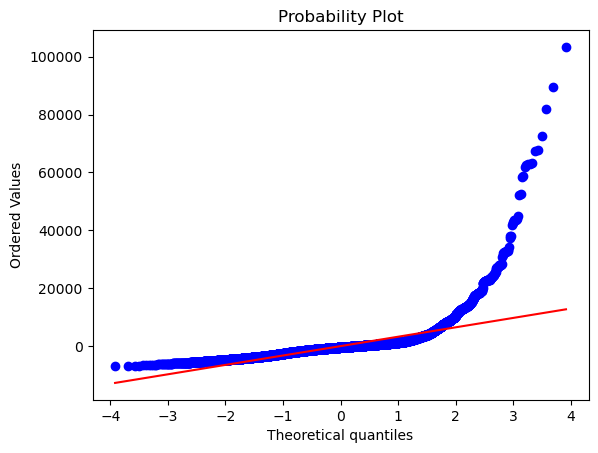

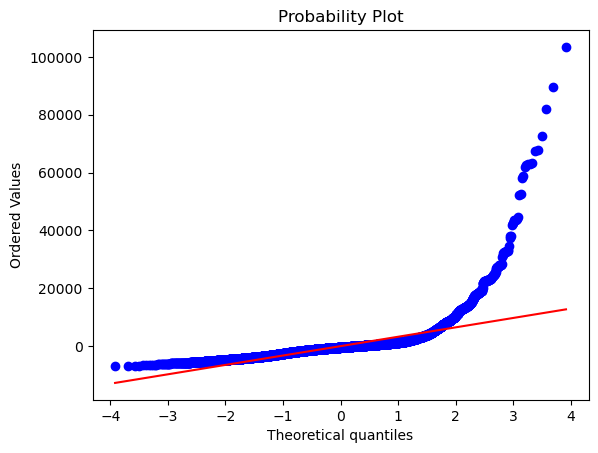

In [152]:
results = regress(Y, X)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.show()

results = regress(Y, X_final)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.show()